# Classificação de partidas de xadrez

Serão criados modelos de classificação para prever o vencedor de partidas de xadrez, baseado em dados pré-processados no projeto anterior.

Análises sobre os dados podem ser encontradas no notebook `ChessGames.ipynb`.

Será utilizado o MLFlow para rastreamento de experimentos e comparação de modelos.

# Configuração do MLFLow

In [1]:
%pip install mlflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
import mlflow
import mlflow.sklearn
import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

warnings.filterwarnings("ignore")

mlflow.set_experiment(experiment_name='Chess games classification')

2024/07/10 15:54:33 INFO mlflow.tracking.fluent: Experiment with name 'Chess games classification' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/Arquivos/Documentos/Faculdade/7p/Intro%20dados/intro-dados/notebooks/mlruns/132817528641291311', creation_time=1720637673702, experiment_id='132817528641291311', last_update_time=1720637673702, lifecycle_stage='active', name='Chess games classification', tags={}>

Definição do método de rastreamento do mlflow:

In [3]:
def mlflow_track(model, model_name: str, params: dict, metrics: dict):
    mlflow.log_params(params)
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(sk_model=model, artifact_path="sklearn-model", registered_model_name=model_name)

Definição do método para plotar resultados do treinamento de um modelo

In [4]:
def plot_grid_search(results: dict[str, np.ndarray], param: str, scores: list[str]):
    plt.figure(figsize=(10, 10))
    plt.title("GridSearchCV evaluating", fontsize=16)

    plt.xlabel(param)
    plt.ylabel("Accuracy Score")

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results["param_%s" % param].data, dtype=float)

    ax = plt.gca()

    for scorer, color in zip(scores, ["g", "k"]):
        for sample, style in (("train", "--"), ("test", "-")):
            sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
            sample_score_std = results["std_%s_%s" % (sample, scorer)]

            ax.fill_between(
                X_axis,
                sample_score_mean - sample_score_std,
                sample_score_mean + sample_score_std,
                alpha=0.1 if sample == "test" else 0,
                color=color,
            )
            ax.plot(
                X_axis,
                sample_score_mean,
                style,
                color=color,
                alpha=1 if sample == "test" else 0.7,
                label="%s (%s)" % (scorer, sample),
            )

        margins = ax.get_ylim()
        ax.set_ylim(margins[0] - 0.1, margins[1] + 0.1)

        best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
        best_score = results["mean_test_%s" % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot(
            [
                X_axis[best_index],
            ]
            * 2,
            [0, best_score],
            linestyle="-.",
            color=color,
            marker="x",
            markeredgewidth=3,
            ms=8,
        )

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

Definição do método de treinamento e rastreamento do mlflow:

In [5]:
def mlflow_train_and_track(model_class, model_name, train_data: pd.DataFrame, target: str, param_grid: dict, params: dict = {}, plot: bool = False):
    # Split the data labels and features
    train_x = train_data.drop([target], axis=1)
    train_y = train_data[[target]]

    # Train the model and track
    with mlflow.start_run(run_name=model_name):
        # Train the model with a grid search
        # GridSearchCV will try all the combinations of the parameters, using cross-validation to evaluate the performance
        model = model_class(**params)
        scores = ["accuracy"]
        gs = GridSearchCV(
            model,
            param_grid=param_grid,
            scoring=scores,
            refit='accuracy',
            n_jobs=-1,
            return_train_score=True
        )
        gs.fit(train_x, train_y)
        results = gs.cv_results_

        best_params = gs.best_params_
        best_index = gs.best_index_
        best_mean_accuracy = results["mean_test_accuracy"][best_index]
        best_std_accuracy = results["std_test_accuracy"][best_index]

        # Print the results
        print("Trained %s. Best result of %0.4f accuracy was achieved with the params: %s"
              %(model_name, best_mean_accuracy, str(best_params).strip("{}")))

        # Log best model to MLflow
        best_model = gs.best_estimator_
        mlflow_track(best_model, model_name, best_params,
                     {"mean_accuracy": best_mean_accuracy, "std_accuracy": best_std_accuracy})

        # Plot the grid search results of the first parameter
        if (plot):
            plot_param = list(param_grid.keys())[0]
            plot_grid_search(results, plot_param, scores)

        

# Treinando os modelos

## Importando o dataset

In [6]:
csv_url = "https://raw.githubusercontent.com/Vinicius-resende-cin/intro-dados/master/data/chess_games_cleaned.csv"
try:
    data = pd.read_csv(csv_url, encoding = "ISO-8859-1")
except Exception as e:
    logger.exception(f"Unable to download training & test CSV, check your internet connection. Error: {e}")

Convertendo tipos para execução dos modelos

In [7]:
data['victory_status'] = data['victory_status'].astype('category')
data['winner'] = data['winner'].astype('category')
data['increment_code'] = data['increment_code'].astype('category')
data['white_id'] = data['white_id'].astype('category')
data['black_id'] = data['black_id'].astype('category')
data['moves'] = data['moves'].astype('category')
data['opening_eco'] = data['opening_eco'].astype('category')
data['opening_name'] = data['opening_name'].astype('category')

In [9]:
data['victory_status'] = data['victory_status'].cat.codes
data['winner'] = data['winner'].cat.codes
data['increment_code'] = data['increment_code'].cat.codes
data['white_id'] = data['white_id'].cat.codes
data['black_id'] = data['black_id'].cat.codes
data['moves'] = data['moves'].cat.codes
data['opening_eco'] = data['opening_eco'].cat.codes
data['opening_name'] = data['opening_name'].cat.codes

In [10]:
data.head()

,id,rated,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,duration_sec,rating_diff,rating_avg,rating_avg_norm
0,4926,False,50,1,0,139,387,1265,2574,1500,1899,222,796,4,916.013,235,1382.5,0.353971
1,16218,False,30,1,0,139,2522,1500,379,1265,7579,183,245,7,885.794,235,1382.5,0.353971
2,8791,False,50,1,0,139,387,1265,2574,1500,3326,0,1176,1,811.024,235,1382.5,0.353971
3,15338,True,10,2,0,292,4155,1099,209,1574,5364,62,927,2,510.205,475,1336.5,0.325203
4,13794,True,21,1,2,301,3281,1459,4150,1143,7620,178,840,6,200.445,316,1301.0,0.303002


## Separando dados de treinamento e de teste

In [11]:
# Split the data into training and test sets. (0.75, 0.25) split.
train_data, test_data = train_test_split(data, random_state=0)

## Executando o treinamento

O treinamento dos modelos será realizado com o GridSearchCV, que testará todas as combinações dos parâmetros, utilizando cross validation para avaliar o desempenho.

Os melhores modelos de cada algoritmo serão então avaliados no conjunto de teste para escolher o algoritmo com melhor desempenho.

### KNN

Trained KNN. Best result of 0.5062 accuracy was achieved with the params: 'n_neighbors': 15


Successfully registered model 'KNN'.
Created version '1' of model 'KNN'.


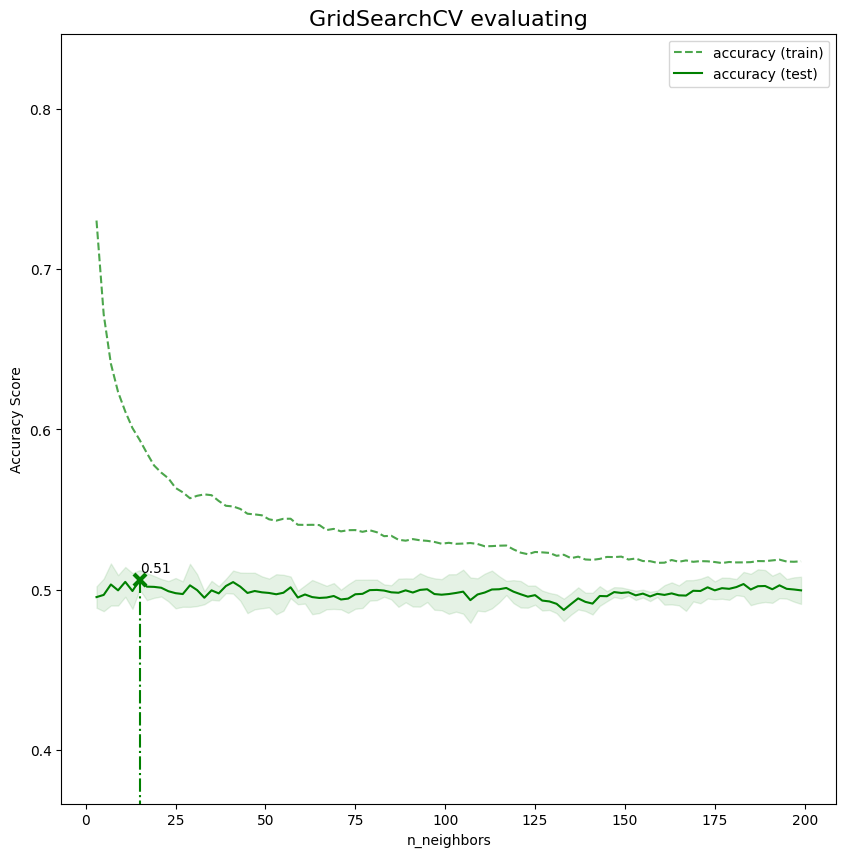

In [12]:
from sklearn.neighbors import KNeighborsClassifier
knn_param_grid = {
    "n_neighbors": range(3, 200, 2)
}
mlflow_train_and_track(KNeighborsClassifier, 'KNN', train_data, 'winner', knn_param_grid, plot=True)

### SVC

Trained SVC. Best result of 0.6705 accuracy was achieved with the params: 'C': 52.099999999999994


Successfully registered model 'SVC'.
Created version '1' of model 'SVC'.


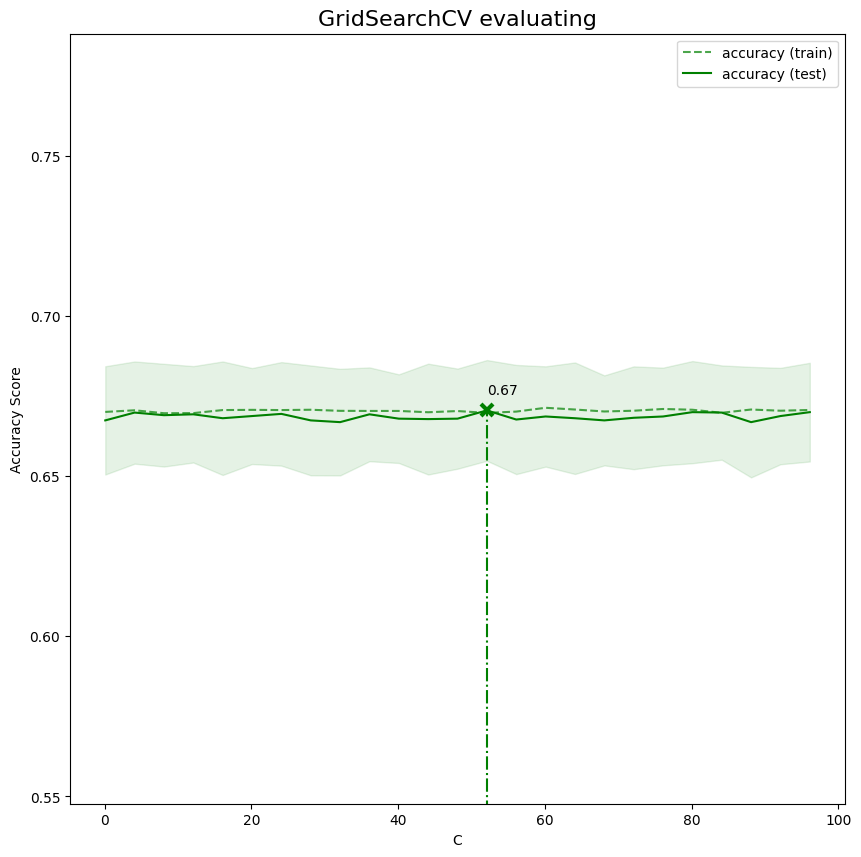

In [13]:
from sklearn.svm import LinearSVC
svc_param_grid = {
    'C': np.arange(0.1, 100.0, 4.0)
}
mlflow_train_and_track(LinearSVC, 'SVC', train_data, 'winner', svc_param_grid, {"random_state": 0}, plot=True)

### Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
random_forest_param_grid = {
    "n_estimators": range(10, 500, 50),
    "max_depth": range(1, 100, 20),
    "min_samples_leaf": range(1, 30, 5)
}
mlflow_train_and_track(RandomForestClassifier, "RandomForest", train_data, "winner", random_forest_param_grid, {"random_state": 0})

Trained RandomForest. Best result of 0.6678 accuracy was achieved with the params: 'max_depth': 21, 'min_samples_leaf': 16, 'n_estimators': 260


Successfully registered model 'RandomForest'.
Created version '1' of model 'RandomForest'.


### MLP

In [15]:
from sklearn.neural_network import MLPClassifier
mlp_param_grid = {
    'alpha': np.arange(0.1, 10.0, 0.5),
    'max_iter': np.arange(100, 1000, 100)
}
mlflow_train_and_track(MLPClassifier, 'MLP', train_data, 'winner', mlp_param_grid, {"random_state": 0})

Trained MLP. Best result of 0.5536 accuracy was achieved with the params: 'alpha': 3.6, 'max_iter': 100


Successfully registered model 'MLP'.
Created version '1' of model 'MLP'.


Os resultados dos melhores modelos foram salvos no formato do mlflow e podem ser acessados por meio da sua interface.

## Avaliando os modelos no conjunto de teste

Para visualizar o rastreamento numa interface, execute o comando abaixo no diretório raiz do repositório:

```bash
mlflow ui --port 5000
```

A interface será acessível no endereço `http://localhost:5000` em um navegador.

A partir dos resultados obtidos durante a validação cruzada, os melhores modelos de cada algoritmo são os seguintes:

- KNN(n_neighbors=15)
- LinearSVC(C=52.1)
- RandomForestClassifier(n_estimators=260, max_depth=21, min_samples_leaf=16)
- MLPClassifier(alpha=3.6, max_iter=100)

No conjunto de validação, os modelos que utilizam os algoritmos SVC e RandomForest alcançaram resultados similares. Para confirmar os resultados, os melhores modelos de cada algoritmo serão avaliados no conjunto de teste para escolher o algoritmo com melhor desempenho.

In [16]:
# Get the best models for each algorithm
best_knn = mlflow.sklearn.load_model("models:/KNN/latest")
knn_run = mlflow.search_runs(search_all_experiments=True, filter_string='tags.mlflow.runName = "KNN"', output_format="pandas").iloc[0]['run_id']
best_knn_params = mlflow.get_run(knn_run).data.params

best_svc = mlflow.sklearn.load_model("models:/SVC/latest")
svc_run = mlflow.search_runs(search_all_experiments=True, filter_string='tags.mlflow.runName = "SVC"', output_format="pandas").iloc[0]['run_id']
best_svc_params = mlflow.get_run(svc_run).data.params

best_rf = mlflow.sklearn.load_model("models:/RandomForest/latest")
rf_run = mlflow.search_runs(search_all_experiments=True, filter_string='tags.mlflow.runName = "RandomForest"', output_format="pandas").iloc[0]['run_id']
best_rf_params = mlflow.get_run(rf_run).data.params

best_mlp = mlflow.sklearn.load_model("models:/MLP/latest")
mlp_run = mlflow.search_runs(search_all_experiments=True, filter_string='tags.mlflow.runName = "MLP"', output_format="pandas").iloc[0]['run_id']
best_mlp_params = mlflow.get_run(mlp_run).data.params

In [17]:
# Test the models
test_x = test_data.drop(['winner'], axis=1)
test_y = test_data[['winner']]

knn_pred = best_knn.predict(test_x)
svc_pred = best_svc.predict(test_x)
rf_pred = best_rf.predict(test_x)
mlp_pred = best_mlp.predict(test_x)

In [18]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy of the models
knn_accuracy = accuracy_score(test_y, knn_pred)
svc_accuracy = accuracy_score(test_y, svc_pred)
rf_accuracy = accuracy_score(test_y, rf_pred)
mlp_accuracy = accuracy_score(test_y, mlp_pred)

# Log the results
for model_name, model, params, accuracy in zip(['KNN', 'SVC', 'RandomForest', 'MLP'],
                           [best_knn, best_svc, best_rf, best_mlp],
                           [best_knn_params, best_svc_params, best_rf_params, best_mlp_params],
                           [knn_accuracy, svc_accuracy, rf_accuracy, mlp_accuracy]):
    with mlflow.start_run(run_name=model_name):
        mlflow_track(model, model_name, params, {"accuracy": accuracy})

Registered model 'KNN' already exists. Creating a new version of this model...
Created version '2' of model 'KNN'.
Registered model 'SVC' already exists. Creating a new version of this model...
Created version '2' of model 'SVC'.
Registered model 'RandomForest' already exists. Creating a new version of this model...
Created version '2' of model 'RandomForest'.
Registered model 'MLP' already exists. Creating a new version of this model...
Created version '2' of model 'MLP'.


Ao verificar o desempenho no conjunto de teste, o modelo do algoritmo Random Forest obteve a melhor acurácia em comparação aos demais, com um score de 0.6848

Sendo assim, esse algoritmo será escolhido como o modelo final para a classificação de partidas de xadrez.

# Diagnóstico do modelo

Apesar de ter obtido o melhor desempenho, o modelo Random Forest ainda possui uma acurácia baixa no conjunto de teste (68.48%), o que indica que o modelo não é capaz de prever corretamente o vencedor da partida em muitos casos. Para melhorar o desempenho do modelo, é necessário realizar um diagnóstico do que pode ser melhorado.

In [19]:
# check training and test errors
train_rf_pred = best_rf.predict(train_data.drop(['winner'], axis=1))
train_error = 1 - accuracy_score(train_data[['winner']], train_rf_pred)
test_error = 1 - rf_accuracy
print("Training error: %0.4f" % train_error)
print("Test error: %0.4f" % test_error)

Training error: 0.1747
Test error: 0.3152


Pode-se notar que o modelo possui uma performance razoável no conjunto de treinamento, mas não generaliza bem para o conjunto de teste, o que é indicado pela alta variância ($31.52 - 17.47 = 14.05$). Para melhorar o desempenho do modelo, é necessário reduzir a variância, o que pode ser feito por meio de técnicas de regularização, aumento do conjunto de dados ou redução da complexidade do modelo.

Para reduzir a complexidade do modelo, será feita uma seleção de features baseada na importância das features no modelo. As features mais importantes serão utilizadas para treinar um novo modelo e avaliar o desempenho no conjunto de teste.

In [20]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_rf, test_x, test_y, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=test_x.columns)

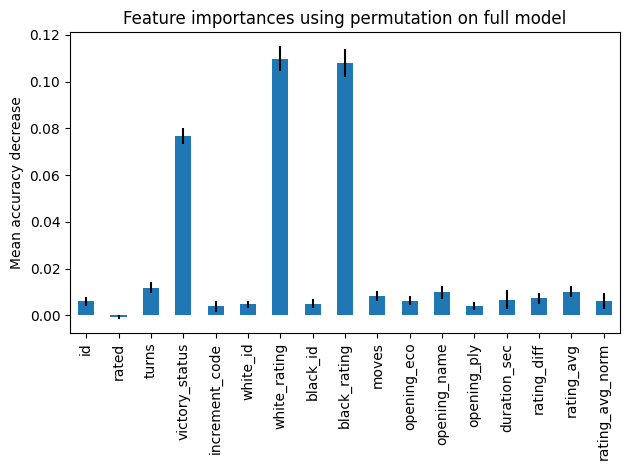

In [21]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

A partir da análise da importância das features, é possível selecionar um subconjunto de features para treinar um novo modelo:

- white_rating
- black_rating
- victory_status
- turns
- opening_name

Essas features serão utilizadas para treinar um novo modelo Random Forest e avaliar o desempenho no conjunto de teste.

In [22]:
# Train a new model with the most important features
new_train_data = train_data[['turns', 'victory_status', 'white_rating', 'black_rating', 'opening_name', 'winner']]

new_random_forest_param_grid = {
    "n_estimators": range(100, 500, 50),
    "max_depth": range(1, 50, 10),
    "min_samples_leaf": range(1, 30, 5)
}
mlflow_train_and_track(RandomForestClassifier, "RandomForest", new_train_data, "winner", new_random_forest_param_grid, {"random_state": 0})


Trained RandomForest. Best result of 0.6760 accuracy was achieved with the params: 'max_depth': 11, 'min_samples_leaf': 6, 'n_estimators': 100


Registered model 'RandomForest' already exists. Creating a new version of this model...
Created version '3' of model 'RandomForest'.


In [23]:
new_train_x = new_train_data.drop(['winner'], axis=1)
new_train_y = new_train_data[['winner']]
new_test_x = test_data[['turns', 'victory_status', 'white_rating', 'black_rating', 'opening_name']]
new_test_y = test_data[['winner']]

new_best_rf = mlflow.sklearn.load_model("models:/RandomForest/latest")
new_train_rf_pred = new_best_rf.predict(new_train_x)
new_rf_pred = new_best_rf.predict(new_test_x)

new_train_error = 1 - accuracy_score(new_train_y, new_train_rf_pred)
new_test_error = 1 - accuracy_score(new_test_y, new_rf_pred)
print("Training error: %0.4f" % new_train_error)
print("Test error: %0.4f" % new_test_error)

Training error: 0.2272
Test error: 0.3103


Avaliando o novo modelo, percebe-se uma melhora nos resultados, obtendo um erro de 31.03%, em comparação a 31.52% do modelo anterior. Apesar de ser uma melhora pequena, é o bastante para provar que a seleção de features é eficaz no objetivo de generalizar o modelo.